In [1]:
!pip install datasets
!pip install sklearn

In [1]:
from datasets import load_from_disk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import torch
from tqdm import tqdm

In [2]:
device = torch.device('cpu')

In [3]:
import os
cdir = os.getcwd()
dataset = load_from_disk(str(cdir) + "/data")
dataset

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 57246
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 10103
    })
})

In [4]:
train_x = torch.load('x_train_tensors.pt', map_location=device)
train_y = dataset['train']['label']

In [5]:
test_x = torch.load('x_test_tensors.pt', map_location=device)
test_y = dataset['test']['label']

In [9]:
from sklearn.model_selection import KFold
import numpy as np

In [10]:
def cross_validation(train_x, train_y, c_values, n_folds):
    kf = KFold(n_splits=n_folds)
    kf.split(train_x)
    
    # minimizing loss = maximizing accuracy
    accuracy_hat = float("-inf")
    all_validation_accuracies = []

    # iterate over all possible hyperparameters c
    for c in tqdm(c_values):
        h = KNeighborsClassifier(n_neighbors = c)
        s, s2 = 0, 0
        
        # do kfold cross validation
        for train_idx, test_idx in kf.split(train_x):
            
            # fit h on training set
            h.fit(train_x[train_idx], np.array(train_y)[train_idx])

            # find the accuracy of h on the validation set 
            accuracy = h.score(train_x[test_idx], 
                               np.array(train_y)[test_idx])

            # update sum of accuracies and accuracy^2
            s, s2 = s + accuracy, s2 + accuracy ** 2

        # calculate mean accuracy over the n folds
        accuracy = s/n_folds

        # if this accuracy is better than the best one so far, store
        # the hyperparameters, classifier, accuracy and variance
        if accuracy > accuracy_hat:
            variance = (s2 - accuracy * s)/(n_folds - 1)
            c_hat, accuracy_hat, variance_hat = c, accuracy, variance
        all_validation_accuracies.append(accuracy)
        
    # refit the model with the optimal hyperparameters c on the entire 
    # data
    h_hat = KNeighborsClassifier(n_neighbors = c_hat)
    h_hat.fit(train_x, train_y)
    return h_hat, accuracy_hat, variance_hat, all_validation_accuracies

In [11]:
import time
start = time.time()
c_vals = [i for i in range(1, 10)]
(h_hat, 
 L_hat, variance_hat, all_validation_accuracies) = cross_validation(train_x, train_y, 
                                                                    c_vals, 3)
end = time.time()
print(end-start)

100%|██████████| 9/9 [12:42<00:00, 84.73s/it]

762.6597502231598


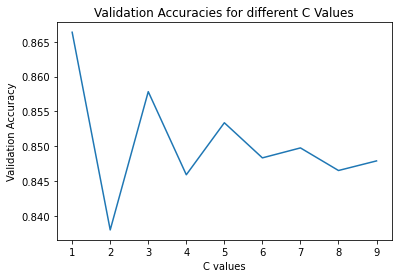

In [12]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.set(xlabel = "C values", ylabel = "Validation Accuracy", 
       title = "Validation Accuracies for different C Values")
plt.plot(c_vals, all_validation_accuracies)

In [13]:
print(h_hat, L_hat, variance_hat)

KNeighborsClassifier(n_neighbors=1) 0.8663836774621808 2.3828046868290542e-05


In [15]:
training_accuracy = h_hat.score(train_x, train_y)
testing_accuracy = h_hat.score(test_x, test_y)

In [16]:
print('Testing accuracy:', testing_accuracy)
print('Training accuracy:', training_accuracy)

Testing accuracy: 0.8849846580223696
Training accuracy: 0.9999475945917619
